Dataset: RAF-DB + FER-2013 + SFEW + AffectNet

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import os
import pandas as pd
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Data Preperation

In [5]:
# Define paths to your training and testing directories
data_dir = 'Datasets/RAF-FER-SFEW-AN'

# Function to add images from a directory to a list
def process_directory(directory, data_list):
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)

        # Check if it's a directory
        if os.path.isdir(class_dir):
            # Loop through each image in the folder
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                # Append to the data list
                data_list.append({'filepath': image_path, 'label': class_name})

# Initialize an empty list for storing data
data_list = []
# Add training images to the data list
process_directory(data_dir, data_list)
# Create a DataFrame from the list
df = pd.DataFrame(data_list)
# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
# Print the amount of images per category before balancing
print("Images per category before balancing:")
print(df['label'].value_counts())
# Determine the label with the least amount of images
min_label_count = df['label'].value_counts().min()
# Reduce all categories to this size by randomly removing entries
balanced_df = df.groupby('label').sample(n=min_label_count, random_state=42).reset_index(drop=True)
# Optionally, shuffle the DataFrame again to ensure mixed labels
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
# Print 15 random samples of the balanced DataFrame
# print(balanced_df.sample(15))
# Print the amount of images per category after balancing
print("\nImages per category after balancing:")
print(balanced_df['label'].value_counts())

Images per category before balancing:
label
happy       19974
neutral     14360
sad         13406
angry       10638
surprise    10366
fear        10059
disgust      5107
Name: count, dtype: int64

Images per category after balancing:
label
disgust     5107
fear        5107
neutral     5107
surprise    5107
angry       5107
sad         5107
happy       5107
Name: count, dtype: int64


# Preprocessing

In [6]:
# Set the image size and batch size
image_size = (96, 96) # Can be increased to improve accuracy or decreased to improve speed. (48, 48) for FER2013, (224, 224) for RAF-DB
batch_size = 64

# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(balanced_df, test_size=0.1, random_state=42)  # 80% training, 20% test
train_df, val_df = train_test_split(train_df, test_size=0.11, random_state=42)  # Of the 80% training, split into 60% training and 20% validation

# Calculate and print split ratios
total_samples = len(df)
train_ratio = len(train_df) / total_samples
val_ratio = len(val_df) / total_samples
test_ratio = len(test_df) / total_samples

print(f"Total samples: {total_samples}")
print(f"Training set: {train_ratio:.2f} ({len(train_df)} samples)")
print(f"Validation set: {val_ratio:.2f} ({len(val_df)} samples)")
print(f"Test set: {test_ratio:.2f} ({len(test_df)} samples)\n")

# Create an ImageDataGenerator for data augmentation (optional)
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=15,  # rotation
    width_shift_range=0.05, # horizontal shift (only 5% since faces are centered)
    height_shift_range=0.05, # vertical shift (only 5% since faces are centered)
    shear_range=0.1, 
    # zoom_range=0.1,   zoom (with current dataset not needed, since faces are centered)
    horizontal_flip=True, # flip images horizontally
    fill_mode='constant', # fill in missing pixels (nearest / constant)
    # brightness_range=[0.8, 1.2] # darken and lighten images
)

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation data
test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for test data

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
# Assuming 'labels' contains your class labels for the training data
labels = train_df['label'].values
unique_classes = np.unique(labels)
# Compute class weights for balanced training
class_weights = compute_class_weight('balanced', classes=unique_classes, y=labels)
# Get class indices from the generator
class_indices = train_generator.class_indices
# Ensure the order of `unique_classes` matches the order in `class_indices`
ordered_unique_classes = sorted(unique_classes, key=lambda x: class_indices[x])
# Create a dictionary mapping class indices to their weights
class_weights_dict = {class_indices[label]: weight for label, weight in zip(ordered_unique_classes, class_weights)}
print(class_weights_dict)

Total samples: 83910
Training set: 0.34 (28634 samples)
Validation set: 0.04 (3540 samples)
Test set: 0.04 (3575 samples)
Found 28634 validated image filenames belonging to 7 classes.
Found 3540 validated image filenames belonging to 7 classes.
Found 3575 validated image filenames belonging to 7 classes.
{0: 1.0092700292552255, 1: 1.0033287781632152, 2: 1.004314124373049, 3: 0.9904531304047043, 4: 0.9938220186033597, 5: 1.0025910364145658, 6: 0.9964851226726988}


# Image before and after preprocessing comparison

In [7]:
# Create a non-preprocessing ImageDataGenerator
no_preprocessing_datagen = ImageDataGenerator()

# Create a temporary generator to fetch a batch of original images
temp_generator = no_preprocessing_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep the same order as the original generator
)

# Function to plot images in a grid
def plot_images(images_arr):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype('uint8'))  # Cast to uint8 for correct image display
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Fetch a batch of original images
original_batch = next(temp_generator)
original_images = original_batch[0][:25]  # Select first 25 images

# Function to plot images in a grid
def plot_images(images_arr):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img, cmap='gray')  # Set the colormap to 'gray'
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images
example_batch = next(train_generator)
example_images = example_batch[0][:25]  # Select first 25 images

# Plot the images
# plot_images(original_images)
# plot_images(example_images)

Found 83910 images belonging to 7 classes.


# Model Definition

In [8]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1.e-9
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        loss = tf.reduce_sum(loss, axis=1)
        return loss
    return focal_loss_fixed

# Previous model architecture neurons per layer: 
# 1. Start with images size (e.g. 224 for RAF-DB, 48 for FER2013) and divide by 2 for each convolutional layer
# 2. Pyramidal model: double the number of filters for each convolutional layer, then halve the number of filters for each convolutional layer (e.g. 64, 128, 256, 128, 64)
# batch_size = 64, learning_rate = 0.0002, l2_reg = 0.002 and dropout = [0.1,0.3] give accuracy of about 50% 062527, 084021 
# batch_size = 64, learning_rate = 0.0002, l2_reg = 0.004 and dropout = [0.3,0.5] doesn't work, on about epoch 4-6 jumps in accuracy in loss and accuracy. Correction: better results are achieved. Overfitting was reduced. 090307, 101603
# batch_size = 256, learning_rate = 0.001, l2_reg = 0.004 and dropout = [0.3,0.5] very bad results. Probably learning rate
# batch_size = 64, learning_rate = 0.0002, l2_reg = 0.003 and dropout = [0.25,0.5] about 50% accuracy. I think least overfitting yet. 20240212_141444

l2_reg = 0.003  # Regularization strength
dropout = [0.25, 0,5]
n_filter = [128, 64, 32, 128]

model = Sequential([
    # First Conv Block
    Conv2D(n_filter[0], (2, 2), padding='same', activation='relu', input_shape=(96, 96, 1), kernel_regularizer=l2(l2_reg)), 
    BatchNormalization(), # Batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation
    MaxPooling2D(pool_size=(2, 2)), # Max pooling reduces computation by reducing the dimensionality of the feature maps
    Dropout(dropout[0]), # Dropout to prevent overfitting
    # Second Conv Block
    Conv2D(n_filter[1], (2, 2), padding='same', activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(dropout[0]),
    # Third Conv Block
    Conv2D(n_filter[2], (2, 2), padding='same', activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(dropout[0]),
    # Flatten and Dense Layers
    Flatten(),
    Dense(n_filter[3], activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Dropout(dropout[1]),
    Dense(7, activation='softmax', kernel_regularizer=l2(l2_reg))  # 7 emotions
])

model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(loss=focal_loss(), optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# model.summary()

# Callbacks

In [9]:
# Early stopping to prevent overfitting. This stops training when the model's performance on the validation set starts to degrade.
early_stopper = EarlyStopping(
    monitor='val_loss',  # Metric to be monitored
    patience=3,         # Number of epochs with no improvement after which training will be stopped. Reduced from 10
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

# Create a ModelCheckpoint callback
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint = ModelCheckpoint(
    f'logs/model_checkpoint_{timestamp}.keras',  # Path where to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=False,    # Save only the best model. Set False to save the model at the end of every epoch so restarting from specific epoch is possible
    save_weights_only=False, # Save only the weights
    mode='min',             # Minimize the monitored metric (val_loss) min before
    verbose=1               # Verbose output
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001,
    cooldown=3,
    verbose=1
)

# Model Training

In [10]:
# Load the last saved weights
# model.load_weights('model_checkpoint.keras')

epochs = 30 # When resuming training, set epochs to the total number of epochs you want to train, not just the additional epochs. The model.fit() method continues training for the specified number of epochs, starting from the current epoch count. Typically, 10 to 100 epochs are used. Start with e.g. 30-50.

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    # class_weight=class_weights_dict,
    callbacks=[early_stopper, checkpoint]
)

# Save the training history for later analysis
with open(f'logs/training_history_{timestamp}.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/30
447/447 [==============================] - ETA: 0s - loss: 3.1567 - accuracy: 0.2019
Epoch 1: saving model to logs/model_checkpoint_20240212_141444.keras
447/447 [==============================] - 413s 920ms/step - loss: 3.1567 - accuracy: 0.2019 - val_loss: 3.9939 - val_accuracy: 0.1565
Epoch 2/30
447/447 [==============================] - ETA: 0s - loss: 2.8036 - accuracy: 0.2493
Epoch 2: saving model to logs/model_checkpoint_20240212_141444.keras
447/447 [==============================] - 418s 934ms/step - loss: 2.8036 - accuracy: 0.2493 - val_loss: 3.0831 - val_accuracy: 0.2361
Epoch 3/30
447/447 [==============================] - ETA: 0s - loss: 2.5992 - accuracy: 0.2729
Epoch 3: saving model to logs/model_checkpoint_20240212_141444.keras
447/447 [==============================] - 427s 956ms/step - loss: 2.5992 - accuracy: 0.2729 - val_loss: 2.7729 - val_accuracy: 0.2804
Epoch 4/30
447/447 [==============================] - ETA: 0s - loss: 2.4198 - accuracy: 0.2973
Epoc

# Evaluation and Visualization

56/56 [==============================] - 12s 213ms/step - loss: 1.5089 - accuracy: 0.4845
Test accuracy:  0.4844755232334137
56/56 [==============================] - 12s 213ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.43      0.42      0.43       537
     disgust       0.44      0.56      0.50       509
        fear       0.49      0.30      0.38       512
       happy       0.75      0.67      0.71       478
     neutral       0.39      0.49      0.43       509
         sad       0.42      0.41      0.41       535
    surprise       0.57      0.55      0.56       495

    accuracy                           0.48      3575
   macro avg       0.50      0.49      0.49      3575
weighted avg       0.49      0.48      0.48      3575

Weighted Precision: 0.4939086045958814
Weighted Recall: 0.4844755244755245
Weighted F1-Score: 0.4839197423029427


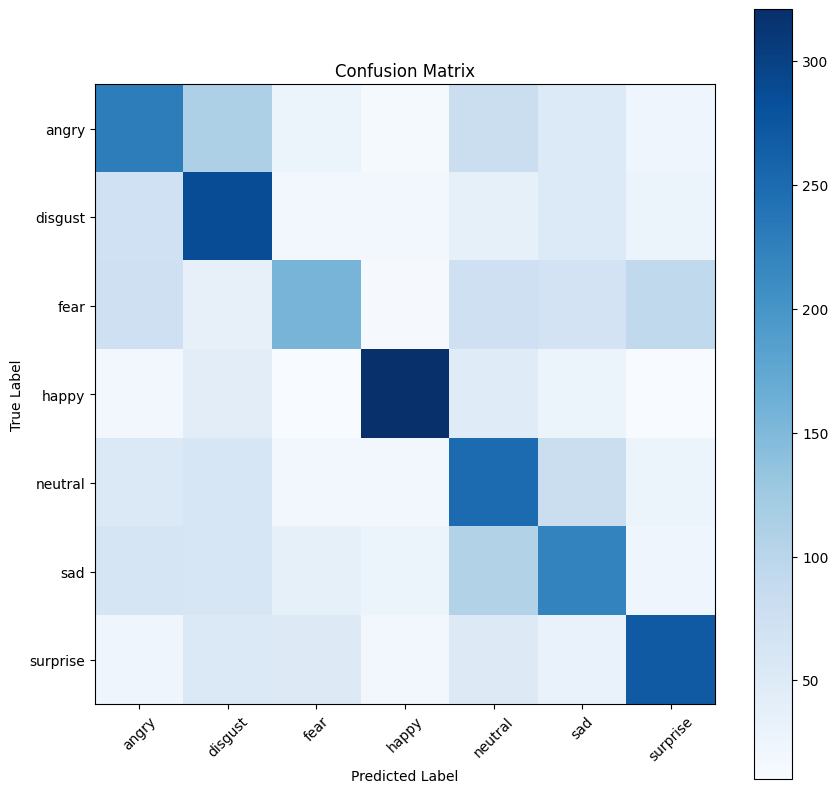

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
print("Test accuracy: ", test_accuracy)

# Predictions on the test set
test_generator.reset() # Ensuring the generator is reset to the beginning
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1) # Convert predictions to class labels

# Since the generator omits some samples due to rounding down in 'steps', we trim 'true_classes' to match 'predicted_classes' length
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]

class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

# Additional weighted metric calculations
weighted_precision = precision_score(true_classes, predicted_classes, average='weighted')
weighted_recall = recall_score(true_classes, predicted_classes, average='weighted')
weighted_f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)
print("Weighted F1-Score:", weighted_f1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Conducting error analysis
This can be done by examining misclassified examples, which can provide insights into what types of errors the model is making

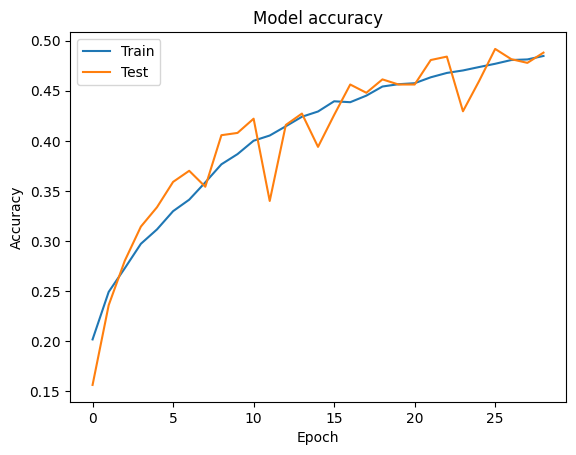

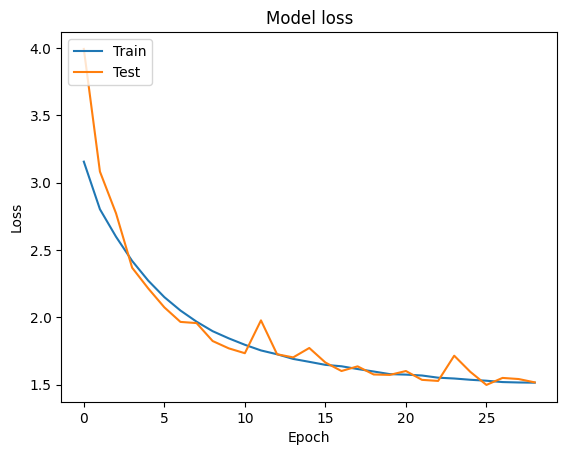

In [16]:
# Learning Curves
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

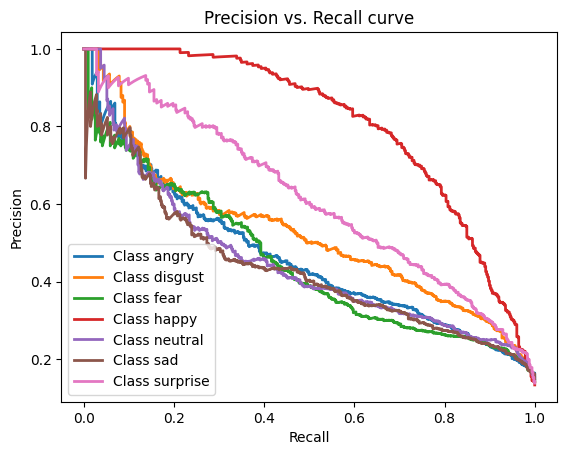

In [17]:
# Precsion-Recall Curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class
y_bin = label_binarize(true_classes, classes=np.arange(len(class_labels)))
n_classes = y_bin.shape[1]

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], predictions[:, i])

# Plot the precision-recall curve
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(class_labels[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

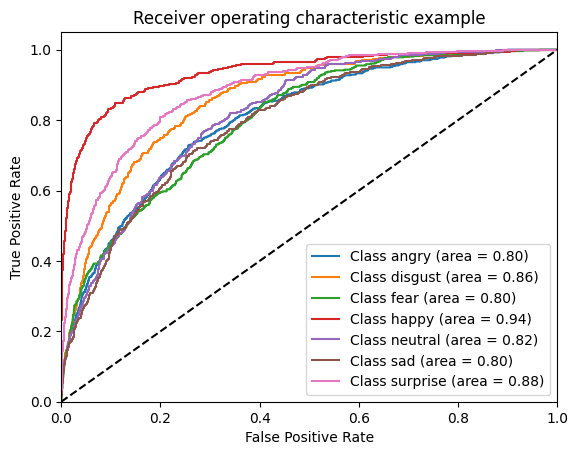

In [18]:
# ROC Curve and AUC
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()